In [1]:
!pip install kmodes

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [23]:
df = pd.read_csv("dataset.csv")

df.head()

,id,time_online,video_clicks,content_anticipation,delay_lectures,fraction_spent,grade
0,0,388,799,17,5,45,17
1,1,471,945,23,6,44,16
2,2,170,716,33,6,12,14
3,3,159,629,23,6,76,16
4,4,286,511,23,3,66,18


# Task 1
## Part 1
We want to predict the grade using raw features.
The class below is a sample neural network implemented in talk!

In [24]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Below is the code for training raw features.

In [56]:
raw_features = df[["time_online", "video_clicks", "content_anticipation", "delay_lectures", "fraction_spent"]].values
target = df['grade'].values

scaler = StandardScaler()
raw_features = scaler.fit_transform(raw_features)

X_train, X_test, y_train, y_test = train_test_split(raw_features, target, test_size=0.2, random_state=0)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).unsqueeze(1)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).unsqueeze(1)

input_size = raw_features.shape[1]
model = Net(input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for i in range(10000):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Now we evaluate our model using test data.
The MSE loss is roughly 1.12

In [57]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    mse = F.mse_loss(y_pred, y_test)
    print(mse.item())
mse_NN_raw = mse.item()

1.1188479661941528


## Part 2
Now we use K-means algorithm to cluster.
Then train our model using clustered features.

In [41]:
effort_clustering = KMeans(n_clusters=2, random_state=0).fit(df[['time_online', 'video_clicks']])
df['effort'] = effort_clustering.labels_

proactivity_clustering = KMeans(n_clusters=2, random_state=0).fit(df[['content_anticipation', 'delay_lectures']])
df['proactivity'] = proactivity_clustering.labels_

control_clustering = KMeans(n_clusters=2, random_state=0).fit(df[['fraction_spent']])
df['control'] = control_clustering.labels_

df.to_csv("dataset_clustered.csv", index=False)

Now train our model using dimensions.

In [42]:
clustered_features = df[["effort", "proactivity", "control"]].values
target = df['grade'].values

scaler = StandardScaler()
clustered_features = scaler.fit_transform(clustered_features)

X_train, X_test, y_train, y_test = train_test_split(clustered_features, target, test_size=0.2, random_state=0)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).unsqueeze(1)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).unsqueeze(1)

input_size = clustered_features.shape[1]
model_clustering = Net(input_size)

criterion_clustering = nn.MSELoss()
optimizer_clustering = optim.Adam(model_clustering.parameters(), lr=0.01)

for i in range(10000):
    outputs = model_clustering(X_train)
    loss = criterion_clustering(outputs, y_train)
    optimizer_clustering.zero_grad()
    loss.backward()
    optimizer_clustering.step()

Now evaluate our model.
The MSE is roughly 0.87

In [43]:
model_clustering.eval()
with torch.no_grad():
    y_pred = model_clustering(X_test)
    mse = F.mse_loss(y_pred, y_test)
    print(mse.item())
mse_NN_clustered = mse.item()

0.8698774576187134


# Task 2
## Part 1
Here we use decision tree classifier to train our model.
First we use raw features.

In [32]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [33]:
df = pd.read_csv("dataset.csv")
df.head()

,id,time_online,video_clicks,content_anticipation,delay_lectures,fraction_spent,grade
0,0,388,799,17,5,45,17
1,1,471,945,23,6,44,16
2,2,170,716,33,6,12,14
3,3,159,629,23,6,76,16
4,4,286,511,23,3,66,18


In [44]:
X_train, X_test, y_train, y_test = train_test_split(raw_features, target, test_size=0.2, random_state=1)

Here we create decision tree with depth 3.
Then predict for test data and the MSE is roughly 1.04.

In [45]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print(metrics.mean_squared_error(y_test, y_pred))
mse_DT_raw = metrics.mean_squared_error(y_test, y_pred)

1.0360360360360361


## Part 2
Now we train our model using clustered features.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(clustered_features, target, test_size=0.2, random_state=1)

Again we create decision tree with depth 3.
Then predict for test data and the MSE is roughly 1.01.

In [47]:
# Create Decision Tree classifer object
clustered_clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clustered_clf = clustered_clf.fit(X_train,y_train)

#Predict the response for test dataset
clustered_y_pred = clustered_clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print(metrics.mean_squared_error(y_test, clustered_y_pred))
mse_DT_clustered = metrics.mean_squared_error(y_test, clustered_y_pred)

1.0135135135135136


# Comparison
Below I Compare 4 results.
I get this part from Mehran Montazer.

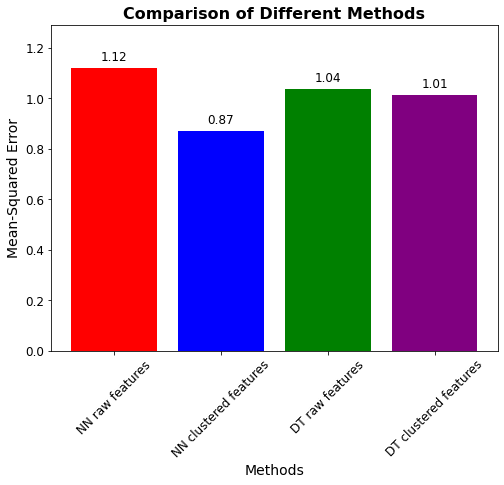

In [58]:
data = [mse_NN_raw, mse_NN_clustered, mse_DT_raw, mse_DT_clustered]
labels = ['NN raw features', 'NN clustered features', 'DT raw features', 'DT clustered features']
colors = ['red', 'blue', 'green', 'purple']

# Create a bar chart with custom colors and rotated labels
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, data, color=colors)
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add x-axis label
ax.set_xlabel('Methods', fontsize=14)

# Add y-axis label
ax.set_ylabel('Mean-Squared Error', fontsize=14)

# Add chart title
ax.set_title('Comparison of Different Methods', fontsize=16, fontweight='bold')

# Adjust y-axis limits to make more space for data labels
label_height = ax.get_ylim()[1] * 0.1
ax.set_ylim([0, ax.get_ylim()[1] + label_height])

# Add data labels on top of each bar
for i, v in enumerate(data):
    ax.text(i, v+0.03, str(round(v, 2)), ha='center', fontsize=12)

# Display the chart
plt.show()